<a href="https://colab.research.google.com/github/eugeneteoh/COMP6247-Reinforcement-Online-Learning/blob/master/lab_4/rbf_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 42

In [3]:
# https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
# scaler = StandardScaler()
X = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat')
X, y = X[:, :-1], X[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
# X_train = scaler.fit_transform(X_train)

N = X_train.shape[0]

# Linear

In [4]:
W = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
y_hat = X_train @ W

In [5]:
mean_squared_error(y_train, y_hat)

915.2883576634607

# Closed Form

In [6]:
def gaussian_func(alpha):
    return np.exp(-alpha**2)

In [7]:
from sklearn.cluster import KMeans

In [8]:
J = 20 # num of clusters
kmeans = KMeans(n_clusters=J, random_state=SEED).fit(X_train)
M = kmeans.cluster_centers_
sigma = np.std(X_train)

In [9]:
U = np.zeros((N, J))
for i in range(N):
    for j in range(J):
        U[i, j] = gaussian_func(np.linalg.norm(X_train[i] - M[j]) / sigma)

In [10]:
W = np.linalg.inv(U.T @ U) @ U.T @ y_train
y_hat = U @ W

In [11]:
mean_squared_error(y_train, y_hat)

35.33514630427382

# Gradient Descent

In [12]:

epochs = 50000
lr = 0.01

W_iter = np.zeros((epochs, J))
W_iter[0] = np.random.randn(J)

mse_iter = np.zeros(epochs)
mse_iter[0] = mean_squared_error(y_train, U @ W_iter[0])


for epoch in range(1, epochs):
    grad = - U.T @ (y_train - U @ W_iter[epoch-1]) / N
    W_iter[epoch] = W_iter[epoch-1] - lr * grad
    mse_iter[epoch] = mean_squared_error(y_train, U @ W_iter[epoch])

In [13]:
mse_iter_gd = mse_iter

In [14]:
mse_argmin = np.argmin(mse_iter)
print(mse_argmin)
print(mse_iter[mse_argmin])

49999
38.6355367542141


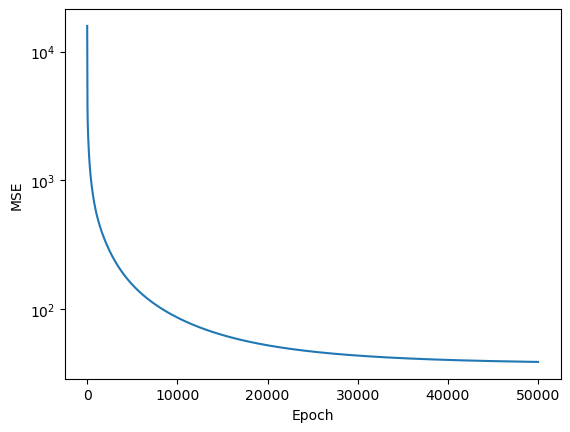

In [19]:
plt.plot(mse_iter_gd)
plt.yscale('symlog')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('gd-loss.pdf')
plt.show()

# Stochastic Gradient Descent

In [20]:
from sklearn.utils import shuffle

In [21]:

epochs = 10000
lr = 0.005
batch_size = 128

W_iter = []
W_iter.append(np.random.randn(J))

mse_iter = []
mse_iter.append(mean_squared_error(y_train, U @ W_iter[0]))

for epoch in range(1, epochs):
    U_train, y_train = shuffle(U, y_train, random_state=SEED)
    
    for i in range(0, U_train.shape[0], batch_size):
        U_train_mini = U_train[i:i+batch_size]
        y_train_mini = y_train[i:i+batch_size]

        grad = - U_train_mini.T @ (y_train_mini - U_train_mini @ W_iter[-1]) / batch_size
        W_iter.append(W_iter[-1] - lr * grad)
        # mse_iter.append(mean_squared_error(y_train_mini, U_train_mini @ W_iter[epoch]))
    mse_iter.append(mean_squared_error(y_train, U_train @ W_iter[-1]))

W_iter = np.array(W_iter)
mse_iter = np.array(mse_iter)

In [22]:
mse_iter_sgd = mse_iter

In [23]:
mse_argmin = np.argmin(mse_iter)
print(mse_argmin)
print(mse_iter[mse_argmin])

9667
48.90566341313149


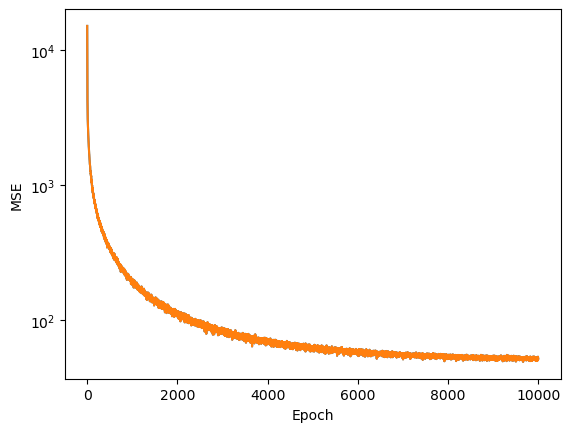

In [25]:
plt.plot(mse_iter_sgd)
plt.yscale('symlog')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('sgd-loss.pdf')
plt.show()

In [80]:
results = pd.DataFrame({'MSE': [915.2883576634607, 33.7546720640081, 49.23499216523326, 48.822702603090676]}, index=['Linear', 'RBF Closed Form', 'RBF GD', 'RBF SGD'])
results

,MSE
Linear,915.288358
RBF Closed Form,33.754672
RBF GD,49.234992
RBF SGD,48.822703


In [81]:
print(results.to_latex(caption="Mean squared error for regression problem.", label="tab:mse-regression"))

\begin{table}
\centering
\caption{Mean squared error for regression problem.}
\label{tab:mse-regression}
\begin{tabular}{lr}
\toprule
{} &         MSE \\
\midrule
Linear          &  915.288358 \\
RBF Closed Form &   33.754672 \\
RBF GD          &   49.234992 \\
RBF SGD         &   48.822703 \\
\bottomrule
\end{tabular}
\end{table}

